<a href="https://colab.research.google.com/github/fsoaresantos/finetuning-resnet18-with-Google-Colab/blob/main/finetuning_resnet18_googlecolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FINETUNING Resnet-18 with Google Colab**

## 1) Enable GPU for the notebook:

1.   Navigate to *Runtime→Change runtime type*

2.   select *GPU* from the Hardware Accelerator drop-down list

3.   save

## 2) verify if GPU is available and print device

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device {device}")

Running on device cuda


## 3) Data preprocessing
*    download CIFAR-10 dataset from {torchvision.datasets},
*    apply data transformation with {torchvision.transforms},
*    parallelize data loading with {torch.utils.data.DataLoader}

In [3]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# number of images in each batch
batch_size=64

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# define train and test data transforms
training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])

testing_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])

# download, transform images, and parallelize the data loading (DataLoader)
trainset = datasets.CIFAR10(root='./data', train=True,
        download=True, transform=training_transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
        shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False,
        download=True, transform=testing_transform)

testloader = DataLoader(testset, batch_size=batch_size,
        shuffle=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 4) Define Test and Train functions

### Test function

In [ ]:
##from IPython.core.debugger import set_trace ## python package for debugging

def test(model, test_loader, criterion):

    # set the network into evaluation mode
    model.eval() # because finetuning

    running_loss=0
    running_corrects=0
    
    with torch.no_grad():
        for batch_n, (inputs, labels) in enumerate(test_loader, 1):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # grab the index (i.e. the class) with the highest probability value for each image within the batch
            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()

            #print(f"Batch: {batch_n}/{len(test_loader)}  Batch loss : {loss.item()}")

        total_loss = running_loss / len(test_loader.dataset)
        total_acc = 100*(running_corrects / len(test_loader.dataset))
        print(f"Test Loss {total_loss}, \ Test Accuracy {total_acc}%")



### Train function

In [ ]:
def train(model, train_loader, validation_loader, criterion, optimizer):
    epochs=5 #10
    best_loss=1e-6
    image_dataset={'train':train_loader, 'valid':validation_loader}

    """
    print(len(image_dataset['train'].dataset), '\n') # 50000 # datasets size
    print(len(image_dataset['train']))               # 782 # loader size (datasets size/batch_size)
    """

    iter_loss = 0
    for epoch in range(epochs): # iterations trough the train and validation datasets
        for phase in ['train', 'valid']:
            print(f"Epoch {epoch+1}, Phase {phase}")
            if phase =='train':
                # set model to train mode (finetuning)
                model.train()
            else:
                # otherwise, validation: set model to eval mode (finetuning)
                model.eval()
            
            correction = 0
            loss_counter = 0

            # training loop: iterations trough the batchs
            for batch_n, (data, target) in enumerate(image_dataset[phase], 1):
                # send data and target to GPU
                data = data.to(device)
                target = target.to(device)
                
                # zero the weights (parameters) gradients for each batch of data
                optimizer.zero_grad()
                
                # enable gradients for training only
                with torch.set_grad_enabled(phase == 'train'):
                    # forward pass
                    outp = model(data)
                    # calculate the loss: returns the weighted mean
                    loss = criterion(outp, target)

                    if phase == 'train':
                        # backward pass: compute gradients of the loss with regard to parameters
                        loss.backward()
                        # update weights
                        optimizer.step()
                    
                    # grab the classes (as indexes) with the highest prediction probability for each image
                    pred = torch.argmax(input=outp, dim=1)

                # statistics
                loss_counter += loss.item() # batch loss: item() returns a Python scalar
                correction += torch.sum(pred==target.data).item() # get the number of correct predictions

                #print(f"Epoch({epoch+1}/{epochs} : Batch number({batch_n}/{len(image_dataset[phase])})  Batch loss : {loss.item()}")

            # print statistics for each phase and epoch
            iter_acc = 100*(correction/len(image_dataset[phase].dataset))
            iter_loss = loss_counter/len(image_dataset[phase].dataset)
            print(f"Iter. Loss {iter_loss}, \ Iter. Accuracy {iter_acc}% \n")

            # track best accuracy
            if phase == 'valid' and iter_loss < best_loss:
                best_loss = iter_loss

        # stops training if validation accuracy stops increasing
        if best_loss == iter_loss:
            break




## 5) Create pretrained model
Two approaches:
1. to train only the last fully connected layer
2. to train from the last CNN block onwards

### 5.1- By replacing the last fully connected layer

In [ ]:
import torch.nn as nn

def create_model_fc():
    # download pretrained resnet18 model
    model = models.resnet18(pretrained = True)

    # print original model and the last fc layer
    #print(model)
    print("FULLY CONNECTED LAYER OF ORIGINAL MODEL:")
    print(model.fc)
    
    # freeze all the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False
    
    # get the numbers of input features in the last fully connected layer
    num_features = model.fc.in_features
    
    # replace the last fully connected layer
    model.fc = nn.Sequential(nn.Linear(in_features = num_features, out_features = 10))

    # print modified fc model layer
    print("\nMODIFIED FULLY CONNECTED LAYER:")
    print(model.fc)

    return model



### 5.2- By unfreezing from the last CNN block onwards

In [ ]:
import torch.nn as nn

def create_model_lastcnn():
    # download pretrained resnet18 model
    model = models.resnet18(pretrained = True)

    # Print original model, the last CNN layer, and the last fc layer
    #print(model)
    print("MODEL LAYER4:")
    print(model.layer4)
    print("\nFULLY CONNECTED LAYER ORIGINAL MODEL:")
    print(model.fc)
    
    # freeze all the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # unfreeze the last block of convolutional layers
    model.layer4[0].conv1.requires_grad = True
    model.layer4[0].bn1.requires_grad = True
    model.layer4[0].relu.requires_grad = True
    model.layer4[0].conv2.requires_grad = True
    model.layer4[0].bn2.requires_grad = True
    model.layer4[0].downsample[0].requires_grad = True
    model.layer4[0].downsample[1].requires_grad = True
    model.layer4[1].conv1.requires_grad = True
    model.layer4[1].bn1.requires_grad = True
    model.layer4[1].relu.requires_grad = True
    model.layer4[1].conv2.requires_grad = True
    model.layer4[1].bn2.requires_grad = True
    
    # get the numbers of input features in the last fully connected layer
    num_features = model.fc.in_features
    
    # replace the last fully connected layer
    model.fc = nn.Sequential(nn.Linear(in_features = num_features, out_features = 10))

    # print modified fc model layer
    print("\nMODIFIED FULLY CONNECTED LAYER:")
    print(model.fc)

    return model


## 6) main code: trainning the model

### 6.1- call function to create the pretrained model (choose one of the approaches above)

In [ ]:
# run this cell if you chose approach 1
model=create_model_fc()

FULLY CONNECTED LAYER OF ORIGINAL MODEL:
Linear(in_features=512, out_features=1000, bias=True)

MODIFIED FULLY CONNECTED LAYER:
Sequential(
  (0): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
# OR, run this cell if you chose approach 2
model=create_model_lastcnn()

MODEL LAYER4:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNor

### 6.2.1- train the model with a **fixed learning rate**

In [ ]:
import torch.optim as optim

# send model to device
model = model.to(device)

# define fixed learning rate
learning_rate = 0.0001

# define criteria for the loss function
criterion = nn.CrossEntropyLoss()

# define optimization criteria (to update the weights)
# take as arguments only the parameters with requires_grad set to True
#optimizer = optim.Adam(model.parameters(), lr=learning_rate) #OR more general as bellow
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# train
train(model, trainloader, testloader, criterion, optimizer)

# send model back to cpu
model = model.to('cpu')

# deploy
test(model, testloader, criterion)


Epoch 1, Phase train
Iter. Loss 0.024097447704076767, \ Iter. Accuracy 53.80200000000001% 

Epoch 1, Phase valid
Iter. Loss 0.016915638345479964, \ Iter. Accuracy 71.23% 

Epoch 2, Phase train
Iter. Loss 0.014850907406806946, \ Iter. Accuracy 73.134% 

Epoch 2, Phase valid
Iter. Loss 0.013161086034774781, \ Iter. Accuracy 75.27000000000001% 

Epoch 3, Phase train
Iter. Loss 0.012502599509954453, \ Iter. Accuracy 75.554% 

Epoch 3, Phase valid
Iter. Loss 0.01173454202413559, \ Iter. Accuracy 77.03% 

Epoch 4, Phase train
Iter. Loss 0.011414174692034722, \ Iter. Accuracy 76.956% 

Epoch 4, Phase valid
Iter. Loss 0.010979181689023971, \ Iter. Accuracy 77.8% 

Epoch 5, Phase train
Iter. Loss 0.010814095015525818, \ Iter. Accuracy 77.652% 

Epoch 5, Phase valid
Iter. Loss 0.010369885385036469, \ Iter. Accuracy 78.64% 

Test Loss 0.01036988283097744, \ Test Accuracy 78.64%


### 6.2.2- train the model with **discriminative learning rates**

In [ ]:
%%time
import torch.optim as optim

# move the model to GPU memory
model = model.to(device)

# define criteria for the loss function
criterion = nn.CrossEntropyLoss()

lrcnn=1e-3
# define optimization criteria (with differential learning rates) to convolutional layers
optimizer = optim.Adam(model.layer4[0].conv1.parameters(), lr=lrcnn)
optimizer = optim.Adam(model.layer4[0].conv2.parameters(), lr=lrcnn*3)
optimizer = optim.Adam(model.layer4[1].conv1.parameters(), lr=lrcnn*6)
optimizer = optim.Adam(model.layer4[1].conv2.parameters(), lr=lrcnn*9)
optimizer = optim.Adam(model.fc.parameters(), lr=lrcnn*12)

# train
train(model, trainloader, testloader, criterion, optimizer)

# send model back to cpu
model = model.to('cpu')

# deploy
test(model, testloader, criterion)


Epoch 1, Phase train
Iter. Loss 0.014078942022323609, \ Iter. Accuracy 72.58% 

Epoch 1, Phase valid
Iter. Loss 0.013729903855919838, \ Iter. Accuracy 75.53% 

Epoch 2, Phase train
Iter. Loss 0.01341783406496048, \ Iter. Accuracy 75.454% 

Epoch 2, Phase valid
Iter. Loss 0.01297529845237732, \ Iter. Accuracy 76.9% 

Epoch 3, Phase train
Iter. Loss 0.013608371386528016, \ Iter. Accuracy 75.97% 

Epoch 3, Phase valid
Iter. Loss 0.01738365305662155, \ Iter. Accuracy 72.09% 

Epoch 4, Phase train
Iter. Loss 0.014194624336957931, \ Iter. Accuracy 75.67399999999999% 

Epoch 4, Phase valid
Iter. Loss 0.012631670363247395, \ Iter. Accuracy 77.62% 

Epoch 5, Phase train
Iter. Loss 0.014663401660621167, \ Iter. Accuracy 75.596% 

Epoch 5, Phase valid
Iter. Loss 0.012476409056782722, \ Iter. Accuracy 78.64999999999999% 

Test Loss 0.012476408272981644, \ Test Accuracy 78.64999999999999%
CPU times: user 30min 47s, sys: 34 s, total: 31min 21s
Wall time: 31min 14s


### 7) Visualization: visualizing predicted images

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

truck


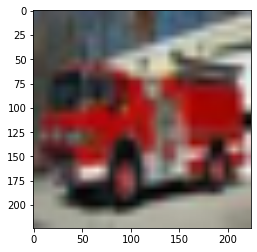

In [ ]:
# select an image id ranging from 0 to 63 (len(pred)-1)
test_image_id=23

def denormalize(tensor):
  """ because images were normalized in the processing step """
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  """ 1) image should be transposed because matplotlib.imshow expects
  the image to be in array shape (row, column, number of chanels); 
  2) denormalize;
  3) finally images should be clipped to assume values between 0 and 1
  for row and column """
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id]

show_img(images[test_image_id])
print(get_CIFAR10_class(pred[test_image_id]))

# References:

*   Transfer Learning for Images Using PyTorch: Essential Training. By Jonathan Fernandes - LinkedIn
*   WELCOME TO PYTORCH TUTORIALS. https://pytorch.org/tutorials/
*   How to use a DataLoader in PyTorch? https://www.geeksforgeeks.org/
*   AWS Machine Learning Engineer Nanodegree - Udacity